In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import gc
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_test_ = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test_.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
df_item_bigcat = pd.read_csv('data/item_categories.csv')
l = list(df_item_bigcat.item_category_name)
l_cat = l
for ind in range(1,8): l_cat[ind] = 'Access'
for ind in range(10,18): l_cat[ind] = 'Consoles'
for ind in range(18,25): l_cat[ind] = 'Consoles Games'
for ind in range(26,28): l_cat[ind] = 'phone games'
for ind in range(28,32): l_cat[ind] = 'CD games'
for ind in range(32,37): l_cat[ind] = 'Card'
for ind in range(37,43): l_cat[ind] = 'Movie'
for ind in range(43,55): l_cat[ind] = 'Books'
for ind in range(55,61): l_cat[ind] = 'Music'
for ind in range(61,73): l_cat[ind] = 'Gifts'
for ind in range(73,79): l_cat[ind] = 'Soft'
df_item_bigcat['bigcat'] = l_cat
df_item_bigcat.head()

,item_category_name,item_category_id,bigcat
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [5]:
df_items = pd.read_csv('data/items.csv')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [7]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [8]:
df_train_piv.reset_index(inplace=True)

In [9]:
df_train_piv = df_train_piv.merge(df_item_bigcat, how="inner", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40,Movie
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [10]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train_piv[['bigcat']] = number.fit_transform(df_train_piv.bigcat)

In [11]:
# df_train_piv['shop_id']= df_train_piv['shop_id'].astype('category')
# df_train_piv['item_id']= df_train_piv['item_id'].astype('category')
# df_train_piv['bigcat']= df_train_piv.bigcat.astype('category')
# df_train_piv['item_category_id']= df_train_piv.item_category_id.astype('category')

In [12]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'item_category_id','bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,7,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,7,0.0,4.0,5.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,40,7,0.0,7.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# %load_ext autoreload
# %autoreload 2
from gatzzt import downcast_dtypes


df_train_piv = downcast_dtypes(df_train_piv)

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_train_piv.iloc[:, :10], alpha=0.2, figsize=(20, 20), diagonal='hist');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1046c2a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a18ab7b00>]], dtype=object)

# Preprocess categories

In [15]:
df_cats = df_train_piv.iloc[:, :4]
df_cats.nunique()

shop_id                60
item_id             21807
item_category_id       84
bigcat                 20
dtype: int64

In [16]:
df_months = df_train_piv.iloc[:, 4:]
df_months.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# xgbost

In [17]:
param = {'max_depth':5, 
         'subsample':0.8,
         'colsample_bytree':0.8,
         'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}

In [21]:
n_months = 30
train_cols = [-4]
bsts = []

for train_col in train_cols:
    X_train = df_months.iloc[:, train_col - n_months:train_col].values
    X_train = np.concatenate((X_train, df_cats.values, df_months.iloc[:, train_col - n_months:train_col].diff(axis=1).values), axis=1)
    y_train = df_months.iloc[:, train_col].values
    
    val_col = train_col + 1
    X_val = df_months.iloc[:, val_col - n_months:val_col].values
    X_val = np.concatenate((X_val, df_cats.values, df_months.iloc[:, val_col - n_months:val_col].diff(axis=1).values), axis=1)
    y_val = df_months.iloc[:, val_col].values
    
#     if train_col == train_cols[0]:
#         X_train_cum, y_train_cum = X_train, y_train
#     else:
#         X_train_cum = np.concatenate((X_train_cum, X_train), axis=0)
#         y_train_cum = np.concatenate((y_train_cum, y_train))
        
    X_train_cum, y_train_cum = X_train, y_train
        
    s = np.arange(X_train_cum.shape[0])
    np.random.shuffle(s)
        
    xgbtrain = xgb.DMatrix(X_train_cum[s], y_train_cum[s])
    xgbval = xgb.DMatrix(X_val, y_val)
    watchlist  = [(xgbtrain,'train'), (xgbval,'val')]
    bst = xgb.train(param, xgbtrain, num_boost_round=100,evals=watchlist, early_stopping_rounds=5)
    bsts.append(bst)
    del X_train, X_val, y_train, y_val, xgbtrain, xgbval
    gc.collect()

[0]	train-rmse:1.29696	val-rmse:1.36931
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 5 rounds.
[1]	train-rmse:1.07477	val-rmse:1.22648
[2]	train-rmse:0.91282	val-rmse:1.1032
[3]	train-rmse:0.807259	val-rmse:1.02934
[4]	train-rmse:0.744314	val-rmse:0.98056
[5]	train-rmse:0.708376	val-rmse:0.956303
[6]	train-rmse:0.671289	val-rmse:0.947176
[7]	train-rmse:0.645786	val-rmse:0.937826
[8]	train-rmse:0.635297	val-rmse:0.933011
[9]	train-rmse:0.620542	val-rmse:0.918768
[10]	train-rmse:0.610672	val-rmse:0.912255
[11]	train-rmse:0.604749	val-rmse:0.908592
[12]	train-rmse:0.598861	val-rmse:0.903098
[13]	train-rmse:0.596317	val-rmse:0.900466
[14]	train-rmse:0.592375	val-rmse:0.89724
[15]	train-rmse:0.590843	val-rmse:0.899941
[16]	train-rmse:0.587035	val-rmse:0.897287
[17]	train-rmse:0.584309	val-rmse:0.89467
[18]	train-rmse:0.582502	val-rmse:0.892868
[19]	train-rmse:0.581181	val-rmse:0.891684
[20]	train-rmse:0.580

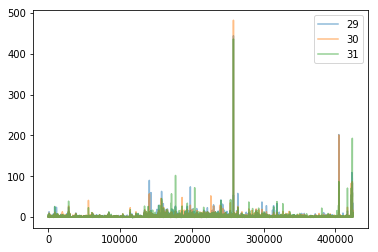

In [35]:
df_months.iloc[:, -5:-2].plot(alpha=0.5)

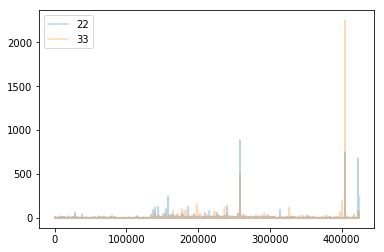

In [40]:
df_months.iloc[:, [-12, -1]].plot(alpha=0.3)

In [22]:
val_col = -1
X_val = df_months.iloc[:, val_col - n_months:val_col].values
X_val = np.concatenate((X_val, df_cats.values, df_months.iloc[:, val_col - n_months:val_col].diff(axis=1).values), axis=1)
y_val = df_months.iloc[:, val_col].values

In [23]:
xgbval = xgb.DMatrix(X_val)
preds = bst.predict(xgbval)
np.sqrt(mean_squared_error(y_val, preds))

3.7573624

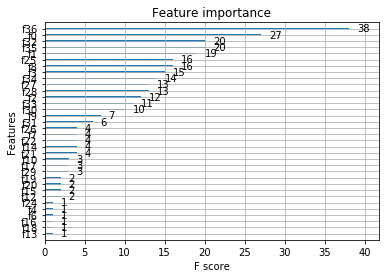

In [38]:
xgb.plot_importance(bst)

In [18]:
df_test = df_test_

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test = np.concatenate((df_test.iloc[:, 1:5].values, df_test.iloc[:, -n_months:].values), axis=1)

In [22]:
xgbtest = xgb.DMatrix(X_test)

In [23]:
preds = []
for bst in bsts:
    preds.append(bst.predict(xgbtest))

In [33]:
preds = np.column_stack(preds)

preds = np.mean(preds, axis=1)

preds = np.clip(preds, 0, 20)

In [34]:
# Normalize prediction to [0-20]
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

# Random Forest

In [25]:
X = df_train_piv.iloc[:,  (df_train_piv.columns != 33)].values
y = df_train_piv.iloc[:, df_train_piv.columns == 33].values.ravel()
shopids = df_train_piv['shop_id'].values

In [41]:


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# train_index, val_index = next(skf.split(X, shopids))
# X_train, y_train = X[train_index], y[train_index]
# X_val, y_val = X[val_index], y[val_index]



# # X, y = sklearn.datasets.load_digits(10,True)
# X_train, X_val, y_train, y_val = train_test_split(X, y)

In [47]:
# from sklearn.ensemble import RandomForestRegressor

# n_estimators = 100
# rf = RandomForestRegressor(warm_start=True, criterion='mse', n_jobs=-1)

# train_scores = []
# val_scores = []
# for i in range(1, n_estimators + 1):
#     rf.set_params(n_estimators=i)
#     rf.fit(X_train, y_train)
#     train_pred = rf.predict(X_train)
#     val_pred = rf.predict(X_val)
#     train_score = np.sqrt(mean_squared_error(train_pred, y_train))
#     val_score = np.sqrt(mean_squared_error(val_pred, y_val))                    
#     print(i, train_score, val_score)

In [44]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
preds = rf.predict(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values)

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"